# Project 2: 
# DSI-US-6 Project 2 Regression Challenge
## Predict the price of homes at sale for the Aimes Iowa Housing dataset

## Table of Contents (Part 2)

### Part 2
7. [Modeling](#7.-Modeling)    
    1. [Base Case](#a.-Base-Case)
1. [Fine Tuning](#8.-Fine-Tuning)  
    1. [Model 1](#a.-Model-1:-Log-y-with-LR-with-same-features-as-baseline-case)
    1. [Model 2](#b.-Model-2:-LR-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 3](#c.-Model-3:-Lasso-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 4](#d.-Model-4:-Ridge-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 5](#e.-Model-5:-Ridge-with-more-features-and-Polynominal)  
    1. [Final Model](#f.-Final-model)
1. [Conclusion and Recommendations](#9.-Conclusion-and-Recommendations)  
1. [References and Data Sources](#10.-References-and-Data-Sources) 

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
# import data

# training set
train_hold = pd.read_csv('../datasets/train_cleaned.csv')
# kaggle test set
test = pd.read_csv('../datasets/test_cleaned.csv')

In [3]:
# loading my data transforming functions

def ordinaltransform(df, col, inplace = False):
    
    '''
    DocString
    ----------
    To rank the features in the database starting with 0 being the poorest/none

       
    Parameters:
    ----------
    df:              Pandas DataFrame which contains the data
    col:             Columns whose data are ordinal to be ranked
    inplace:         True / False. To change the dataframe in place
    
    '''
    
    dict =  {
            'Street': {x: idx for idx, x in enumerate(['Grvl', 'Pave'])},
            'Alley' : {x: idx for idx, x in enumerate(['None','Grvl', 'Pave'])},
            'Lot Shape' : {x: idx for idx, x in enumerate(['Reg', 'IR1', 'IR2', 'IR3'][::-1])},
            'Utilities' : {x: idx for idx, x in enumerate(['AllPub', 'NoSewr','NoSeWa', 'ELO'][::-1])},
            'Land Slope' : {x: idx for idx, x in enumerate(['Gtl','Mod', 'Sev'][::-1])},
            'Exter Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Exter Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Bsmt Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Bsmt Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Bsmt Exposure' : {x: idx for idx, x in enumerate(['Gd', 'Av', 'Mn', 'No', 'None'][::-1])},
            'BsmtFin Type 1' : {x: idx for idx, x in enumerate(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ' ,'Unf', 'None'][::-1])},
            'BsmtFin Type 2' : {x: idx for idx, x in enumerate(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ' ,'Unf', 'None'][::-1])},
            'Heating QC' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Central Air' : {x: idx for idx, x in enumerate(['N', 'Y'])},
            'Electrical' : {x: idx for idx, x in enumerate(['SBrkr','FuseA', 'FuseF', 'FuseP', 'Mix'][::-1])},
            'Kitchen Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Functional' : {x: idx for idx, x in enumerate(['Typ', 'Min1', 'Min2','Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'][::-1])},
            'Fireplace Qu' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Garage Finish' : {x: idx for idx, x in enumerate(['Fin', 'RFn', 'Unf', 'None'][::-1])},
            'Garage Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Garage Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Paved Drive' : {x: idx for idx, x in enumerate(['Y','P','N'][::-1])},
            'Pool QC' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','None'][::-1])},
            'Fence'  : {x: idx for idx, x in enumerate(['GdPrv', 'MnPrv','GdWo', 'MnWw', 'None'][::-1])},
            'Overall Qual' : {},
            'Overall Cond': {}
            }
    if inplace:
        for column in col:
            df[column].replace(dict[column], inplace = inplace)
    
    else:
        temp = df.copy(deep=True)
        for column in col:
            temp[column].replace(dict[column], inplace = True)
        return temp

## 7. Modeling

#### Spliting the training data into train and hold sets

In [4]:
omit = ['PID','SalePrice'] #omit id and saleprice columns

train_hold = train_hold.set_index('Id')
y = train_hold['SalePrice']
X = train_hold.drop(columns=omit)

X_train, X_hold, y_train, y_hold = train_test_split(X, 
                                                    y,
                                                    train_size = 0.75, 
                                                    random_state = 42)

Function of different linear regession models and their results (with pred y vs y)

In [5]:
def mylr(X,y):
    
    '''
    DocString
    ----------
    To fit features into a OLS model.
    Print the CVscore and RSME
    Plot a predicted y vs y plot.
    
    Return the model
       
    Parameters:
    ----------
    X:      DataFrame of features data
    y:      Series/Array target data
    
    '''
    
    lr = LinearRegression()
    lr.fit(X, y)
    
    cvscore = cross_val_score(lr, 
                              X,
                              y,
                              cv = 10,
                              scoring = 'neg_root_mean_squared_error'
                             ).mean()
    
    rmse  = (mean_squared_error(y,lr.predict(X)))**0.5
    
    print(f'Cross_val_score: {cvscore}')  
    print(f'Root_mean_squared_error: {rmse}')
       
#   y_pred vs y plot
    y_predict = lr.predict(X)   
    y_max = y.max()
    y_min = y.min()
    plt.figure(figsize=(10,6))
    plt.scatter(y,y_predict)
    plt.plot((y_min,y_max),(y_min,y_max))
    plt.title('Predicted y vs y from data')
    plt.xlabel('y from data')
    plt.ylabel('Predicted y')
          
    return lr

In [6]:
def mylasso(X, y):
    
    '''
    DocString
    ----------
    To fit features into a Lasso model with the best alpha
    Print the CVscore, RSME and alpha
    Plot a predicted y vs y plot.
    
    Return the model
       
    Parameters:
    ----------
    X:      DataFrame of features data
    y:      Series/Array target data
    
    '''

    lassocv = LassoCV(n_alphas = 200)
    lassocv.fit(X, y)
    alpha = lassocv.alpha_
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X,y)
    
    cvscore = cross_val_score(lasso, 
                              X,
                              y,
                              cv = 10,
                              scoring = 'neg_root_mean_squared_error'
                             ).mean()
    
    rmse  = (mean_squared_error(y,lasso.predict(X)))**0.5
    
    print(f'Cross_val_score: {cvscore}')  
    print(f'Root_mean_squared_error: {rmse}')
    print(f'alpha: {alpha}')
       
#   y_pred vs y plot
    y_predict = lasso.predict(X)
    y_max = y.max()
    y_min = y.min()
    plt.figure(figsize=(10,6))
    plt.scatter(y,y_predict)
    plt.plot((y_min,y_max),(y_min,y_max))
    plt.title('Predicted y vs y from data')
    plt.xlabel('y from data')
    plt.ylabel('Predicted y')
          
    return lasso

In [7]:
def myridge(X, y):
    
    '''
    DocString
    ----------
    To fit features into a Ridge model with the best alpha
    Print the CVscore, RSME and alpha
    Plot a predicted y vs y plot.
    
    Return the model
       
    Parameters:
    ----------
    X:      DataFrame of features data
    y:      Series/Array target data
    
    '''

    ridgecv = RidgeCV(alphas = np.logspace(-2,4,200))
    ridgecv.fit(X, y)
    alpha = ridgecv.alpha_
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X,y)
    
    cvscore = cross_val_score(ridge, 
                              X,
                              y,
                              cv = 10,
                              scoring = 'neg_root_mean_squared_error'
                             ).mean()
    
    rmse  = (mean_squared_error(y,ridge.predict(X)))**0.5
    
    print(f'Cross_val_score: {cvscore}')  
    print(f'Root_mean_squared_error: {rmse}')
    print(f'alpha: {alpha}')
       
#     y_pred vs y plot
    y_predict = ridge.predict(X)
    y_max = y.max()
    y_min = y.min()
    plt.figure(figsize=(10,6))
    plt.scatter(y,y_predict)
    plt.plot((y_min,y_max),(y_min,y_max))
    plt.title('Predicted y vs y from data')
    plt.xlabel('y from data')
    plt.ylabel('Predicted y')
          
    return ridge

In [8]:
def test_model(model,X,y):
    
    '''
    DocString
    ----------
    To predict the outcome of a model on a test set
    Print the CVscore, RSME and alpha
    Plot a predicted y vs y plot.
    
    No return
       
    Parameters:
    ----------
    model:  Model to be tested on
    X:      DataFrame of features data (test set)
    y:      Series/Array target data (test set)
    
    '''
    
    cvscore = cross_val_score(model, 
                              X,
                              y,
                              cv = 10,
                              scoring = 'neg_root_mean_squared_error'
                             ).mean()
    
    rmse  = (mean_squared_error(y,model.predict(X)))**0.5
    
    print(f'Cross_val_score: {cvscore}')  
    print(f'Root_mean_squared_error: {rmse}')
       
#     y_pred vs y plot
    y_predict = model.predict(X)   
    y_max = y.max()
    y_min = y.min()
    plt.figure(figsize=(10,6))
    plt.scatter(y,y_predict)
    plt.plot((y_min,y_max),(y_min,y_max))
    plt.title('Predicted y vs y from data')
    plt.xlabel('y from data')
    plt.ylabel('Predicted y')

### a. Base Case

In [9]:
features_1 = ['Year Built', 'TotRms AbvGrd', 'Total Bsmt SF', 'Gr Liv Area','Garage Area', 'Misc Val', 
              'Overall Qual', 
              'MS Zoning', 'Condition 1', 'Roof Matl', 'Heating', 'Garage Type', 'Sale Type', 'MS SubClass']
target = 'SalePrice'
features_1_continuous = ['Year Built', 'TotRms AbvGrd', 'Gr Liv Area','Total Bsmt SF', 'Garage Area', 'Misc Val']
features_1_ordinal = ['Overall Qual']
features_1_nominal = ['MS Zoning', 'Condition 1', 'Roof Matl', 'Heating', 'Garage Type', 'Sale Type', 'MS SubClass']

In [10]:
id = X_train.index

X_train_continuous = X_train[features_1_continuous+features_1_ordinal]
X_train_nominal = X_train[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_1_ordinal,inplace = True)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous,X_train_ohe], axis = 1)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -31316.29090402276
Root_mean_squared_error: 29983.911144227157


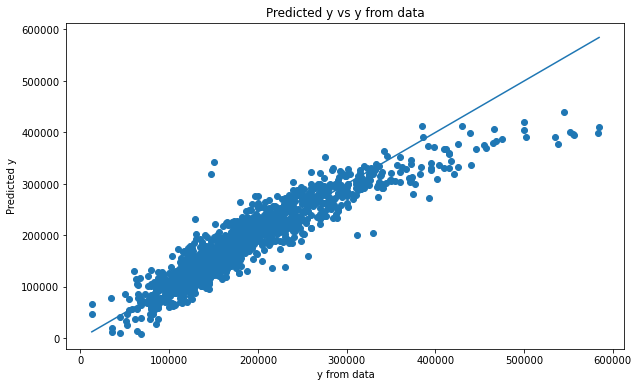

In [11]:
model_baseline = mylr(X_train_combined, y_train)

In [12]:
# Trying it on the holdout set

id = X_hold.index

X_hold_continuous = X_hold[features_1_continuous+features_1_ordinal]
X_hold_nominal = X_hold[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_hold_continuous,features_1_ordinal,inplace = True)

# OneHotEncoding the nominal features
X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe= pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous,X_hold_ohe], axis = 1)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -35305.284895374345
Root_mean_squared_error: 32617.201467612456


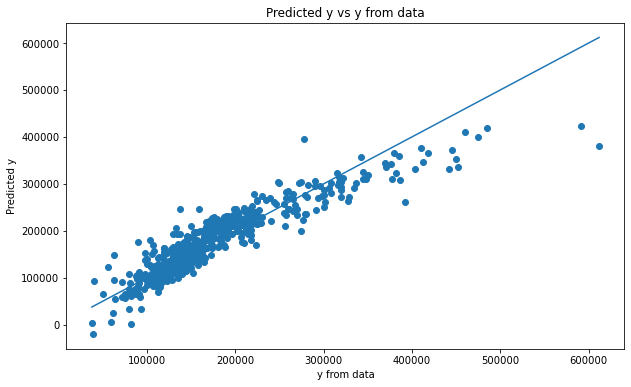

In [13]:
test_model(model_baseline, X_hold_combined, y_hold)

#### Evaluation

Our baseline score will be -29983 on the train set using a OLS model. We will further tune the model to beat this baseline score.
From the graph, we observed that our Predicted y underpredict for the range y more than 300,000. It appears that the model is better in the range where y is between (100,000 to 300,000)

## 8. Fine Tuning

Here we will try to improve the model by:
1. Changing the model
1. Adding / removing / changing the features
1. Transformation the features, these includes 
    1. adding polynominal to account for interactive features or 
    1. scale the target by log
1. Removing outliners from the training set
1. Changing the hyperparameter

### a. Model 1: Log y with LR with same features as baseline case

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -0.15503194977608326
Root_mean_squared_error: 0.14342382965911116


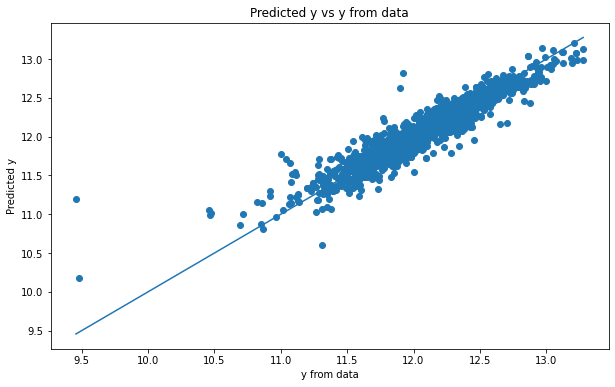

In [14]:
id = X_train.index

X_train_continuous = X_train[features_1_continuous+features_1_ordinal]
X_train_nominal = X_train[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_1_ordinal,inplace = True)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous,X_train_ohe], axis = 1)

y_train_log = np.log(y_train)

model_lr1 = mylr(X_train_combined,y_train_log)

In [15]:
y_hat = model_lr1.predict(X_train_combined)
y_hat = np.exp(y_hat)

rmse  = (mean_squared_error(y_train,y_hat))**0.5
print(f'RMSE: {rmse}')

RMSE: 25514.213526668223


Cross_val_score: -0.15245016878303577
Root_mean_squared_error: 0.14650375589564574


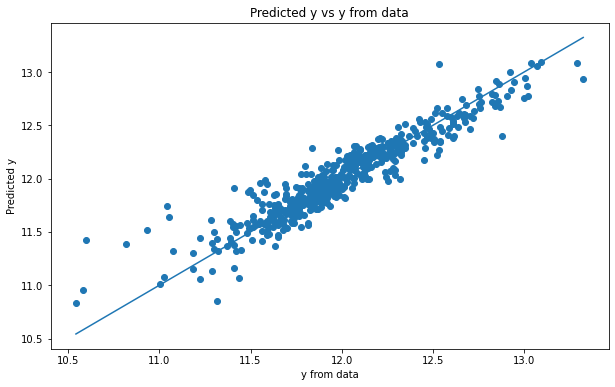

In [16]:
# Trying it on the holdout set

id = X_hold.index

X_hold_continuous = X_hold[features_1_continuous+features_1_ordinal]
X_hold_nominal = X_hold[features_1_nominal]

# OneHotEncoding the nominal features
X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe= pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous,X_hold_ohe], axis = 1)

y_hold_log = np.log(y_hold)

test_model(model_lr1, X_hold_combined, y_hold_log)

In [17]:
# print RMSE
y_hat = model_lr1.predict(X_hold_combined)
y_hat = np.exp(y_hat)

rmse  = (mean_squared_error(y_hold,y_hat))**0.5
print(f'RMSE: {rmse}')

RMSE: 27129.08695867828


There is signifiance in the result with log y improving the RMSE score of the hold out set from 35124 to 30254

### b. Model 2: LR with same features as baseline case and Polynominal

Cross_val_score: -28229.78079654777
Root_mean_squared_error: 25037.023875437117


C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


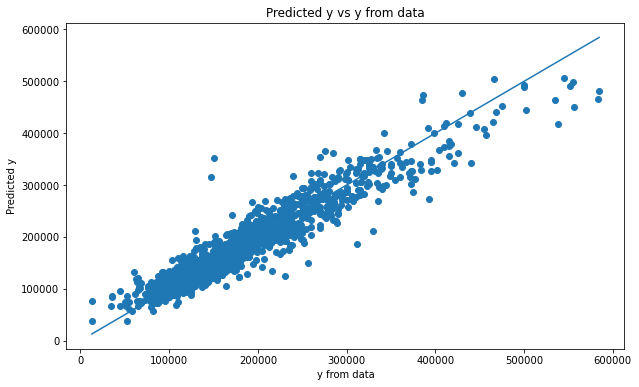

In [18]:
id = X_train.index

X_train_continuous = X_train[features_1_continuous+features_1_ordinal]
X_train_nominal = X_train[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_1_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
poly = PolynomialFeatures(degree=2, include_bias = False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)
X_train_continuous_poly= pd.DataFrame(X_train_continuous_poly, index=id)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous_poly,X_train_ohe], axis = 1)

model_lr2 = mylr(X_train_combined,y_train)

Cross_val_score: -32582.589419758493
Root_mean_squared_error: 26179.21027648826


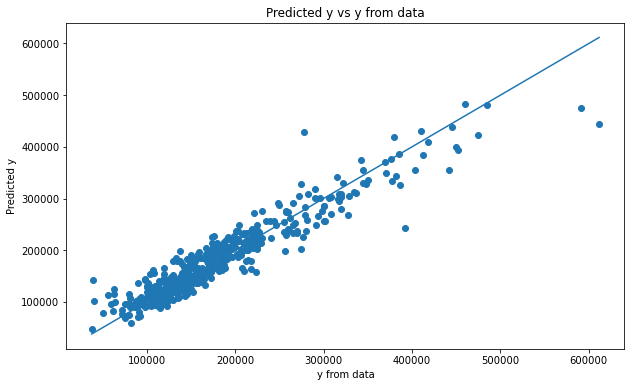

In [19]:
# Trying it on the holdout set

id = X_hold.index

# PolynomialFeatures on the continuous and ordinal features
X_hold_continuous = X_hold[features_1_continuous+features_1_ordinal]
X_hold_continuous_poly = poly.transform(X_hold_continuous)
X_hold_continuous_poly= pd.DataFrame(X_hold_continuous_poly, index=id)

# OneHotEncoding the nominal features
X_hold_nominal = X_hold[features_1_nominal]
X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe= pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous_poly,X_hold_ohe], axis = 1)

test_model(model_lr2, X_hold_combined, y_hold)

### c. Model 3: Lasso with same features as baseline case and Polynominal

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044538174.93396, tolerance: 782189399.4502169
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 842614734.9150391, tolerance: 755344358.4859105
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site

Cross_val_score: -26975.47258572551
Root_mean_squared_error: 26141.98868349895
alpha: 87.65630392858623


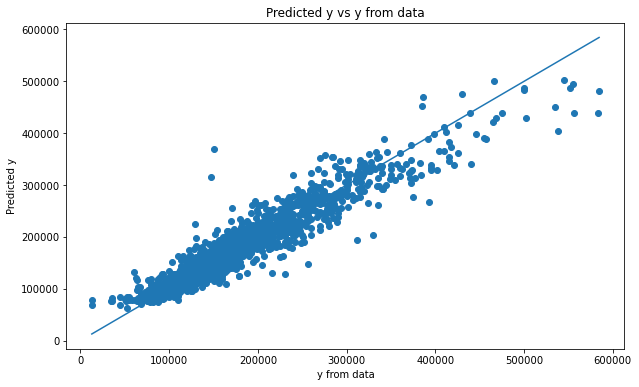

In [20]:
id = X_train.index

X_train_continuous = X_train[features_1_continuous+features_1_ordinal]
X_train_nominal = X_train[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_1_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
poly = PolynomialFeatures(degree=2, include_bias = False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)

# Standardise on the continuous and ordinal features
ss = StandardScaler()
X_train_continuous_poly_sc = ss.fit_transform(X_train_continuous_poly)
X_train_continuous_poly_sc = pd.DataFrame(X_train_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous_poly_sc,X_train_ohe], axis = 1)

model_lasso1 = mylasso(X_train_combined,y_train)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 947508958.8580627, tolerance: 301314402.46629804
  model = cd_fast.enet_coordinate_descent(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2573991383.0121155, tolerance: 312789947.7755661
  model = cd_fast.enet_coordinate_descent(
C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packag

Cross_val_score: -27844.298159713064
Root_mean_squared_error: 26178.242690945724


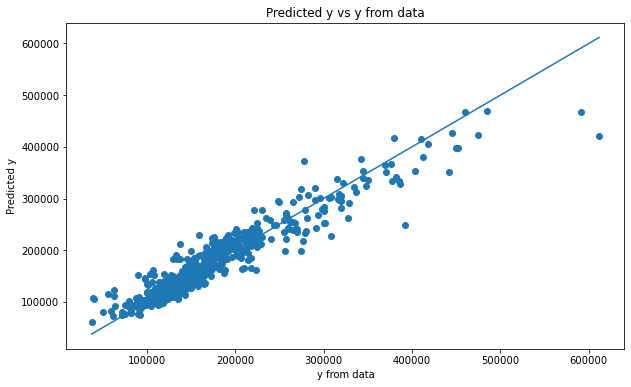

In [21]:
# Trying it on the holdout set

id = X_hold.index

X_hold_continuous = X_hold[features_1_continuous+features_1_ordinal]
X_hold_nominal = X_hold[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_hold_continuous,features_1_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
X_hold_continuous_poly = poly.transform(X_hold_continuous)

# Standardise on the continuous and ordinal features
X_hold_continuous_poly_sc = ss.transform(X_hold_continuous_poly)
X_hold_continuous_poly_sc = pd.DataFrame(X_hold_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe = pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous_poly_sc, X_hold_ohe], axis = 1)

test_model(model_lasso1, X_hold_combined, y_hold)

### d. Model 4: Ridge with same features as baseline case and Polynominal

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -27019.003310002787
Root_mean_squared_error: 25495.654238923875
alpha: 3.180625692794119


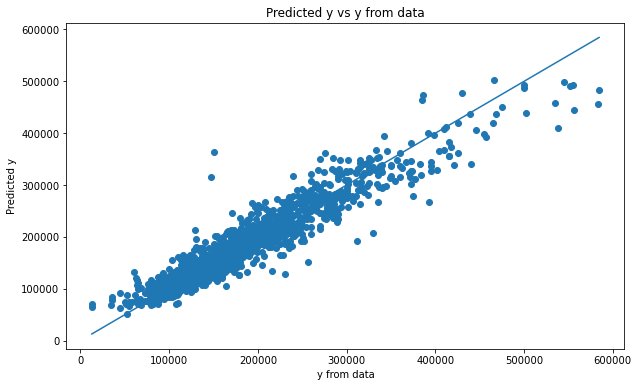

In [22]:
id = X_train.index

X_train_continuous = X_train[features_1_continuous+features_1_ordinal]
X_train_nominal = X_train[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_1_ordinal,inplace = True)
# PolynomialFeatures on the continuous and ordinal features
poly = PolynomialFeatures(degree=2, include_bias = False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)

# Standardise on the continuous and ordinal features
ss = StandardScaler()
X_train_continuous_poly_sc = ss.fit_transform(X_train_continuous_poly)
X_train_continuous_poly_sc = pd.DataFrame(X_train_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous_poly_sc,X_train_ohe], axis = 1)

model_ridge1 = myridge(X_train_combined,y_train)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -27933.01748578027
Root_mean_squared_error: 26019.28855638986


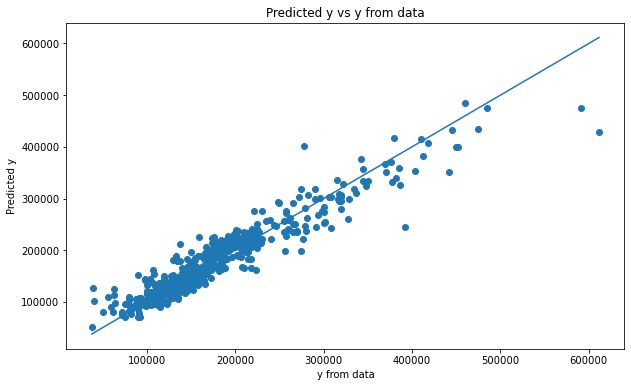

In [23]:
id = X_hold.index

X_hold_continuous = X_hold[features_1_continuous+features_1_ordinal]
X_hold_nominal = X_hold[features_1_nominal]

# Rank the ordinal features
ordinaltransform(X_hold_continuous,features_1_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
X_hold_continuous_poly = poly.transform(X_hold_continuous)

# Standardise on the continuous and ordinal features
X_hold_continuous_poly_sc = ss.transform(X_hold_continuous_poly)
X_hold_continuous_poly_sc = pd.DataFrame(X_hold_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe = pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous_poly_sc, X_hold_ohe], axis = 1)

test_model(model_ridge1, X_hold_combined, y_hold)

### e. Model 5: Ridge with more features and Polynominal  
Let's try to overfit the model and use Ridge to regularise the overfit

In [24]:
features_2 = ['Year Built', 'TotRms AbvGrd', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Misc Val',
              'Year Remod/Add', '1st Flr SF', 'Lot Area',
              'Overall Qual',
              'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish',
              'MS Zoning', 'Condition 1', 'Garage Type', 'MS SubClass',
             'Neighborhood']
target = 'SalePrice'
features_2_continuous = ['Year Built', 'TotRms AbvGrd', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Misc Val',
                        'Year Remod/Add', '1st Flr SF', 'Lot Area' ]
features_2_ordinal = ['Overall Qual',
                      'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish']
features_2_nominal = ['MS Zoning', 'Condition 1', 'Garage Type', 'MS SubClass',
                     'Neighborhood']

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -23789.680357259287
Root_mean_squared_error: 22180.982528725814
alpha: 33.700643292719285


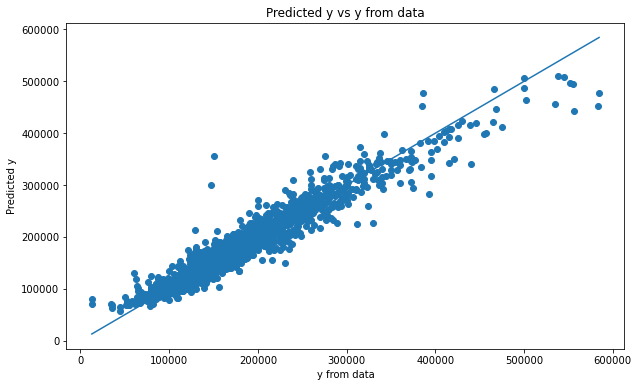

In [25]:
id = X_train.index

X_train_continuous = X_train[features_2_continuous+features_2_ordinal]
X_train_nominal = X_train[features_2_nominal]

# Rank the ordinal features
ordinaltransform(X_train_continuous,features_2_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
poly = PolynomialFeatures(degree=2, include_bias = False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)

# Standardise on the continuous and ordinal features
ss = StandardScaler()
X_train_continuous_poly_sc = ss.fit_transform(X_train_continuous_poly)
X_train_continuous_poly_sc = pd.DataFrame(X_train_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_ohe = hot.fit_transform(X_train_nominal)
X_train_ohe= pd.DataFrame(X_train_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_combined = pd.concat([X_train_continuous_poly_sc,X_train_ohe], axis = 1)

model_ridge2 = myridge(X_train_combined,y_train)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -23730.011933324073
Root_mean_squared_error: 22873.634263179232


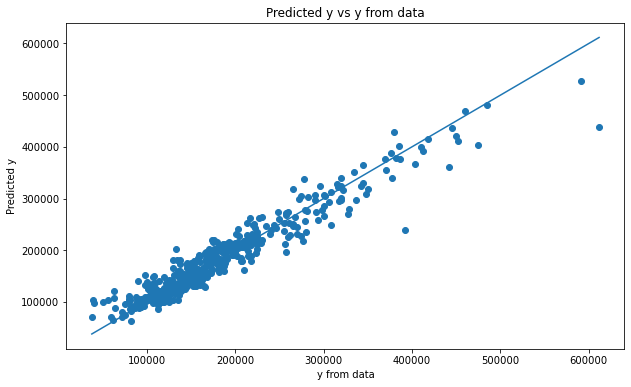

In [26]:
# Trying it on the holdout set</summary>

id = X_hold.index
X_hold_continuous = X_hold[features_2_continuous+features_2_ordinal]
X_hold_nominal = X_hold[features_2_nominal]

# Rank the ordinal features
ordinaltransform(X_hold_continuous,features_2_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
X_hold_continuous_poly = poly.transform(X_hold_continuous)

# Standardise on the continuous and ordinal features
X_hold_continuous_poly_sc = ss.transform(X_hold_continuous_poly)
X_hold_continuous_poly_sc = pd.DataFrame(X_hold_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features

X_hold_ohe = hot.transform(X_hold_nominal)
X_hold_ohe= pd.DataFrame(X_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_hold_combined = pd.concat([X_hold_continuous_poly_sc, X_hold_ohe], axis = 1)

test_model(model_ridge2, X_hold_combined, y_hold)

### f. Final model

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Cross_val_score: -23176.024495774796
Root_mean_squared_error: 22018.329002591498
alpha: 31.440354715915


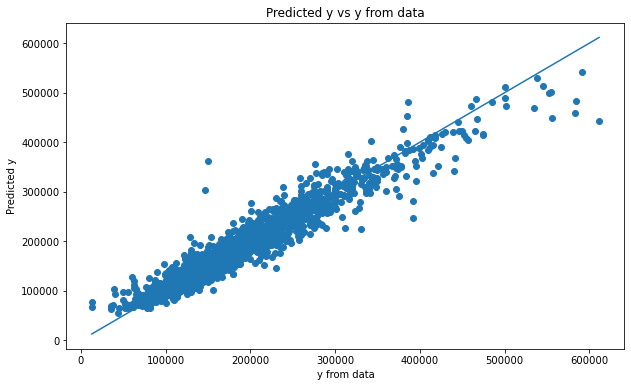

In [27]:
#training the final model on the bigger set of test_hold

X_train_hold = train_hold
y_train_hold = train_hold[target]

id = X_train_hold.index
X_train_hold_continuous = X_train_hold[features_2_continuous+features_2_ordinal]
X_train_hold_nominal = X_train_hold[features_2_nominal]

# Rank the ordinal features
ordinaltransform(X_train_hold_continuous,features_2_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
poly = PolynomialFeatures(degree=2, include_bias = False)
X_train_hold_continuous_poly = poly.fit_transform(X_train_hold_continuous)

# Standardise on the continuous and ordinal features
ss = StandardScaler()
X_train_hold_continuous_poly_sc = ss.fit_transform(X_train_hold_continuous_poly)
X_train_hold_continuous_poly_sc = pd.DataFrame(X_train_hold_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features
hot = OneHotEncoder(sparse=False)
X_train_hold_ohe = hot.fit_transform(X_train_hold_nominal)
X_train_hold_ohe= pd.DataFrame(X_train_hold_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_train_hold_combined = pd.concat([X_train_hold_continuous_poly_sc,X_train_hold_ohe], axis = 1)

model_ridge3 = myridge(X_train_hold_combined,y_train_hold)

In [28]:
# Trying it on the test set

X_test = test
id = X_test['Id']
X_test_continuous = X_test[features_2_continuous+features_2_ordinal]
X_test_nominal = X_test[features_2_nominal]

# Rank the ordinal features
ordinaltransform(X_test_continuous,features_2_ordinal,inplace = True)

# PolynomialFeatures on the continuous and ordinal features
X_test_continuous_poly = poly.transform(X_test_continuous)

# Standardise on the continuous and ordinal features
X_test_continuous_poly_sc = ss.transform(X_test_continuous_poly)
X_test_continuous_poly_sc = pd.DataFrame(X_test_continuous_poly_sc, index=id)

# OneHotEncoding the nominal features

X_test_ohe = hot.transform(X_test_nominal)
X_test_ohe= pd.DataFrame(X_test_ohe, index=id)

# combine all the scaled continous and ordinal features with the nominal features in 1 dataframe
X_test_combined = pd.concat([X_test_continuous_poly_sc, X_test_ohe], axis = 1)

y_predict = model_ridge3.predict(X_test_combined)

C:\Users\nk23d\anaconda3\envs\dsi\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


#### Generating prediction results for Kaggle submission

In [29]:
y_predict = pd.DataFrame(y_predict, index=id)
y_predict.rename(columns = {0:'SalePrice'}, inplace = True)
y_predict.to_csv('../datasets/results.csv')

## 9. Conclusion and Recommendations

| Model    |              | RMSE  | Features | Linear Model | Hyper Parameter | Preprocessing |     |        |       |
|---------:|--------------|-------|----------|--------------|-----------------|:-------------:|-----|--------|-------|
|          |              |       |          |              |                 | Poly          | OHE | Target | Log y |
| Baseline | Train        | 29983 | 1        | LR           |                 |               | Y   |        |       |
|          | Hold         | 32617 |          |              |                 |               |     |        |       |
| Model 1  | Train        | 25514 | 1        | LR           |                 |               | Y   |        | Y     |
|          | Hold         | 27129 |          |              |                 |               |     |        |       |
| Model 2  | Train        | 25037 | 1        | LR           |                 | Y             | Y   |        |       |
|          | Hold         | 26179 |          |              |                 |               |     |        |       |
| Model 3  | Train        | 26141 | 1        | Lasso        | 65.38           | Y             | Y   |        |       |
|          | Hold         | 26178 |          |              |                 |               |     |        |       |
| Model 4  | Train        | 25495 | 1        | Ridge        | 11.89           | Y             | Y   |        |       |
|          | Hold         | 26019 |          |              |                 |               |     |        |       |
| Model 5  | Train        | 22180 | 2        | Ridge        | 33.7            | Y             | Y   |        |       |
|          | Hold         | 22873 |          |              |                 |               |     |        |       |
|          | Train + Hold | 22018 |          |              | 27.364          |               |     |        |       |
|          | Test         | 24842 |          |              |                 |               |     |        |       |

From the RMSE of the different models, our best model is Model 5 which have a RMSE score of 22873 on our holding set and 24842 on the Kaggle Test set. This model is a Ridge Regression model with 19 features, polynomised the continuous and ordinate data to a order of 2 and one hot encode the nominal data. 

Our strategy on the EDA was to categorised the features into quantitative and qualitative data and then into similar characteristics like sizes and quality etc. For each group, we try to filter out the features which have little or no correlation with the SalePrice and also those which are not effective is categorizing the SalePrice into different ranges. We also look at the interaction between the features and if they are correlated with one another. 

We discover that year built, ground living area, total rooms of the house and value of miscellanous features impact the Sale price greatly. Newer, bigger ground living area and higher total rooms increase the Sale price. Surprisingly lot area doesn't add alot more value to the Sale price as much as the ground living area. Excellent external quality and overall quality also add value to the SalePrice. Bigger garage area and bulit-in garage type and new sale type also contribute greatly to increase the SalePrice. We recommend homeowners who are looking to increase their sale price can renovate a built in garage and improve the quality of their exterior material. The neighbourhoods with higher SalePrice are Stone Brook and Northridge

From our base model, we notice that our predicted y underpredict for the range y more than 300,000. Also when we were doing EDA, a portion of the features show heteroskedasticity so we suspect interaction between the features which we try to linearise by using log y and adding polynominal features of order 2. We also used Ridge Regression to regularize the extra features in set 2. Both these help to reduce our RSME scores greatly.

## 10. References and Data Sources

1. https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/submissions